# Zalando Bot: AI-Powered Fashion Assistant

> Retriever - Hybrid search with Milvus

In [ ]:
%pip install -qU pymilvus==2.4.6
%pip install -qU "pymilvus[model]"
%pip install -qU langchain-milvus==0.1.4

In [1]:
import base64
import os
from io import BytesIO

import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import PIL
from PIL import Image
from IPython.core.display import HTML
from IPython.display import display, HTML
from base64 import b64encode

In [2]:
import nltk                                 # type: ignore
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/thivav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
from pymilvus import (
    connections,
    utility,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    AnnSearchRequest,
    WeightedRanker
)

In [4]:
from milvus_model.hybrid import BGEM3EmbeddingFunction          # type: ignore
from langchain_milvus.utils.sparse import BM25SparseEmbedding   # type: ignore

In [5]:
import torch                                            # type: ignore
from sentence_transformers import SentenceTransformer   # type: ignore

## Load dataset

In [2]:
# load the dataset
img_uri = '../data/master_data/zalando_fashionista_x300'
metadata_uri = '../data/master_data/metadata.csv'

In [3]:
metadata = pd.read_csv(metadata_uri)
metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,x100_img,x300_img
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",NaN,NaN,JAM22T04V-O14_x100.jpg,JAM22T04V-O14_x300.jpg
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",IJ022T03E-K11_x100.jpg,IJ022T03E-K11_x300.jpg
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",NaN,NaN,SU222T0VZ-M11_x100.jpg,SU222T0VZ-M11_x300.jpg
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",NaN,NaN,OM422T06R-Q11_x100.jpg,OM422T06R-Q11_x300.jpg
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",IC622T05X-Q11_x100.jpg,IC622T05X-Q11_x300.jpg


In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192126 entries, 0 to 192125
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   sku                  192126 non-null  object
 1   name                 192126 non-null  object
 2   brand                192126 non-null  object
 3   category             192126 non-null  object
 4   url                  192126 non-null  object
 5   sizes                192126 non-null  object
 6   classification       192126 non-null  object
 7   original_price       192126 non-null  object
 8   discount_percentage  73406 non-null   object
 9   promotional_price    73151 non-null   object
 10  x100_img             192126 non-null  object
 11  x300_img             192126 non-null  object
dtypes: object(12)
memory usage: 17.6+ MB


## Preprocess dataset

### Process image

In [5]:
# add x300_img image uri
metadata['img_uri'] = metadata['x300_img'].apply(lambda i: os.path.join(img_uri, i))

# drop image tags
metadata.drop(columns=['x100_img', 'x300_img'], inplace=True)

metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,img_uri
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",NaN,NaN,../data/master_data/zalando_fashionista_x300/J...
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",../data/master_data/zalando_fashionista_x300/I...
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",NaN,NaN,../data/master_data/zalando_fashionista_x300/S...
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",NaN,NaN,../data/master_data/zalando_fashionista_x300/O...
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",../data/master_data/zalando_fashionista_x300/I...


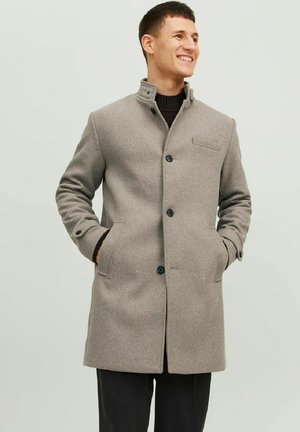

In [6]:
image = Image.open(metadata.iloc[0]['img_uri'])
image

### Process metadata

In [7]:
metadata.fillna(0, inplace=True)
metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,img_uri
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",0,0,../data/master_data/zalando_fashionista_x300/J...
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",../data/master_data/zalando_fashionista_x300/I...
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",0,0,../data/master_data/zalando_fashionista_x300/S...
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",0,0,../data/master_data/zalando_fashionista_x300/O...
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",../data/master_data/zalando_fashionista_x300/I...


In [8]:
def create_product_description(row):
    # extract the necessary columns
    sku = row['sku']
    name = row['name']
    brand = row['brand']
    category = row['category']
    url = row['url']
    sizes = row['sizes']
    classification = row['classification']
    original_price = row['original_price']
    discount_percentage = row['discount_percentage']
    promotional_price = row['promotional_price']

    # add SKU (if relevant for your use case)
    description = f"SKU: {sku}\n"

    # start building the description
    description += f"Product Name: {name} by {brand}.\n"
    description += f"Category: {category}. Status: {classification}.\n"

    # add available sizes, if present
    if pd.notna(sizes):
        description += f"Available Sizes: {sizes}.\n"
    
    # add price and promotional information
    if pd.notna(original_price) and pd.notna(promotional_price) and original_price != 0 and promotional_price != 0:
        description += f"Original Price: {original_price}, now available for {promotional_price}.\n"
        if pd.notna(discount_percentage) and discount_percentage != 0:
            description += f"Discount: {discount_percentage} off.\n"
    elif pd.notna(original_price) and original_price != 0:
        description += f"Price: {original_price}.\n"
    
    # add URL for reference
    description += f"More details can be found at: {url}.\n"   
    
    return description

In [10]:
metadata['description'] = metadata.apply(create_product_description, axis=1)
metadata.head()

,sku,name,brand,category,url,sizes,classification,original_price,discount_percentage,promotional_price,img_uri,description
0,JAM22T04V-O14,BLAMELTON SN - Short coat - greige,Jack & Jones PREMIUM,['Coats'],https://en.zalando.de/jack-and-jones-premium-j...,"[{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}...",[],"149,99 €",0,0,../data/master_data/zalando_fashionista_x300/J...,SKU: JAM22T04V-O14\nProduct Name: BLAMELTON SN...
1,IJ022T03E-K11,Parka - navy,INDICODE JEANS,['Coats'],https://en.zalando.de/indicode-jeans-parka-nav...,"[{'size': 'S', 'sku': 'IJ022T03E-K11000S000'},...",['DEAL'],"114,99 €",up to -9%,"104,99 €",../data/master_data/zalando_fashionista_x300/I...,SKU: IJ022T03E-K11\nProduct Name: Parka - navy...
2,SU222T0VZ-M11,Winter coat - duffle bag,Superdry,['Coats'],https://en.zalando.de/superdry-winter-coat-duf...,"[{'size': 'S', 'sku': 'SU222T0VZ-M11000S000'},...",[],"239,99 €",0,0,../data/master_data/zalando_fashionista_x300/S...,SKU: SU222T0VZ-M11\nProduct Name: Winter coat ...
3,OM422T06R-Q11,Short coat - black,Ombre,['Coats'],https://en.zalando.de/ombre-classic-coat-black...,"[{'size': 'S', 'sku': 'OM422T06R-Q11000S000'},...",['NEW'],"100,99 €",0,0,../data/master_data/zalando_fashionista_x300/O...,SKU: OM422T06R-Q11\nProduct Name: Short coat -...
4,IC622T05X-Q11,CLIMA IGLU - Winter coat - schwarz,ICEBOUND,"['Coats', 'Jackets']",https://en.zalando.de/icebound-waterproof-jack...,"[{'size': 'S', 'sku': 'IC622T05X-Q11000S000'},...",['DEAL'],"289,95 €",up to -52%,"139,76 €",../data/master_data/zalando_fashionista_x300/I...,SKU: IC622T05X-Q11\nProduct Name: CLIMA IGLU -...


In [11]:
metadata.iloc[0]['description'], metadata.iloc[1]['description'], metadata.iloc[100]['description']

("SKU: JAM22T04V-O14\nProduct Name: BLAMELTON SN - Short coat - greige by Jack & Jones PREMIUM.\nCategory: ['Coats']. Status: [].\nAvailable Sizes: [{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}, {'size': 'M', 'sku': 'JAM22T04V-O14000M000'}, {'size': 'L', 'sku': 'JAM22T04V-O14000L000'}, {'size': 'XL', 'sku': 'JAM22T04V-O1400XL000'}, {'size': 'XXL', 'sku': 'JAM22T04V-O140XXL000'}].\nPrice: 149,99\xa0€.\nMore details can be found at: https://en.zalando.de/jack-and-jones-premium-jprblamelton-classic-coat-greige-jam22t04v-o14.html.\n",
 "SKU: IJ022T03E-K11\nProduct Name: Parka - navy by INDICODE JEANS.\nCategory: ['Coats']. Status: ['DEAL'].\nAvailable Sizes: [{'size': 'S', 'sku': 'IJ022T03E-K11000S000'}, {'size': 'M', 'sku': 'IJ022T03E-K11000M000'}, {'size': 'XL', 'sku': 'IJ022T03E-K1100XL000'}, {'size': 'XXL', 'sku': 'IJ022T03E-K110XXL000'}].\nOriginal Price: 114,99\xa0€, now available for 104,99\xa0€.\nDiscount: up to -9% off.\nMore details can be found at: https://en.zalando.de/indicod

In [12]:
# save processed metadata
metadata.drop(columns=['name', 'brand', 'category', 'url', 'sizes', 'classification', 'original_price', 'discount_percentage', 'promotional_price',], axis=1, inplace=True)
metadata.to_csv("../data/processed_data/metadata.csv", index=False)

## Sparse Vectors

### Approach - 1 | BGE-M3 Model for Embeddings

The BGE-M3 model can embed texts as dense and sparse vectors. 

In [ ]:
bgem3_func = BGEM3EmbeddingFunction(use_fp16=False, device="cpu")

In [ ]:
bgem3 = bgem3_func(metadata['description'].values.tolist())

In [ ]:
bgem3["sparse"][0]

In [ ]:
# generate embeddings for the query
query = "I'm looking for blue jeans"
query_embeddings = bgem3([query])
print(query_embeddings)

### Approach - 2 | BM25 Sparse Embeddings

In [15]:
# initialize bn25 sparse embedding
bm25 = BM25SparseEmbedding(corpus=metadata['description'].values.tolist())

In [16]:
# get the sparse embedding for the text using BM25
desc = metadata.iloc[0]['description']
sparse_embedding = bm25.embed_documents([desc])[0]
print("Description:\n", desc, "\nSparse embedding:\n", sparse_embedding)

Description:
 SKU: JAM22T04V-O14.
Product Name: BLAMELTON SN - Short coat - greige by Jack & Jones PREMIUM.
Category: ['Coats']. Status: [].
Available Sizes: [{'size': 'XS', 'sku': 'JAM22T04V-O1400XS000'}, {'size': 'M', 'sku': 'JAM22T04V-O14000M000'}, {'size': 'L', 'sku': 'JAM22T04V-O14000L000'}, {'size': 'XL', 'sku': 'JAM22T04V-O1400XL000'}, {'size': 'XXL', 'sku': 'JAM22T04V-O140XXL000'}].
Price: 149,99 €.
More details can be found at: https://en.zalando.de/jack-and-jones-premium-jprblamelton-classic-coat-greige-jam22t04v-o14.html.
 
Sparse embedding:
 {0: 2.0180094, 1: 1.0275096, 2: 1.0275096, 3: 1.0275096, 4: 1.0275096, 5: 1.0275096, 6: 1.0275096, 7: 1.4564235, 8: 1.0275096, 9: 1.0275096, 10: 1.0275096, 11: 1.0275096, 12: 1.0275096, 13: 1.0275096, 14: 1.0275096, 15: 2.0180094, 16: 1.0275096, 17: 1.0275096, 18: 1.0275096, 19: 1.0275096, 20: 1.0275096, 21: 1.0275096, 22: 1.0275096, 23: 1.0275096, 24: 1.0275096, 25: 1.0275096, 26: 1.0275096, 27: 1.0275096, 28: 1.0275096, 29: 1.0275096,

In [17]:
# get sparse vector for query
query = metadata.iloc[0]['description']
bm25.embed_query(query)

{0: 17.589735,
 1: 11.760439,
 2: 2.9316223,
 3: 2.9316223,
 4: 10.1509695,
 5: 7.0743876,
 6: 2.8655388,
 7: 4.932938,
 8: 8.541376,
 9: 4.0157776,
 10: 4.2970443,
 11: 3.041832,
 12: 2.9316223,
 13: 2.9316223,
 14: 2.9316223,
 15: 17.589735,
 16: 0.8514801,
 17: 11.760439,
 18: 0.0069745816,
 19: 11.760439,
 20: 0.020716205,
 21: 11.760439,
 22: 0.18307638,
 23: 11.760439,
 24: 0.6927217,
 25: 11.760439,
 26: 2.9316223,
 27: 5.3394723,
 28: 2.9316223,
 29: 2.9316223,
 30: 2.9316223,
 31: 2.9316223,
 32: 11.760439}

In [18]:
# get sparse vector for query
query = "I'm looking for blue jeans"
bm25.embed_query(query)

{18: 0.0069745816, 37: 1.9650525, 124: 2.1074085, 429: 6.068903}

## Dence Vectors

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)

model

Device:  cuda


/mnt/d/vault/devhub/zalando_query_bot/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


SentenceTransformer(
  (0): CLIPModel()
)

In [20]:
dense_embeds = model.encode(Image.open(metadata.iloc[0]['img_uri']))
dense_embeds

array([-2.35475779e-01,  2.50805497e-01,  3.30579519e-01, -3.39500099e-01,
       -3.21310014e-03, -1.94906279e-01, -5.85595131e-01, -6.19489074e-01,
        6.30457640e-01,  9.32789594e-03,  5.57257533e-01,  9.18295979e-02,
        3.47834051e-01, -8.79598036e-02,  3.26484203e-01, -3.90736938e-01,
        9.62883353e-01, -2.06306130e-02, -2.10524440e-01, -3.25649679e-02,
       -1.45459235e-01, -3.49872679e-01,  1.03979319e-01, -4.76337969e-01,
        8.63197818e-03,  1.23787418e-01,  3.23910832e-01,  4.02664274e-01,
        3.36602509e-01,  5.22312149e-02,  5.58949530e-01, -3.76302361e-01,
       -6.66438788e-02,  4.75720853e-01, -2.79456437e-01,  1.71079129e-01,
       -9.77896526e-02,  8.26570243e-02, -5.28125107e-01,  1.68679023e+00,
       -2.04118639e-01,  3.44958603e-01,  2.77139306e-01,  4.41111863e-01,
        2.54084229e-01, -8.32443416e-01, -1.98797032e-01, -7.70658180e-02,
       -9.32312384e-03,  5.73620535e-02,  7.70010233e-01, -3.00624371e-02,
       -1.70285255e-01, -

In [21]:
dense_dim = len(dense_embeds)
dense_dim

512

## Connect to Milvus

In [22]:
milvus_db_uri = "../data/db/milvus_db/zalando_fashionista.db"
connections.connect(uri=milvus_db_uri)

## Create Milvus Collection and load data

### Create Milvus collection

In [23]:
# define field names and their data types
pk_field = "doc_id"
sku_field = "sku"
dense_field = "dense_vector"
sparse_field = "sparse_vector"

fields = [
    FieldSchema(name=pk_field, dtype=DataType.VARCHAR, is_primary=True, auto_id=True, max_length=100),
    FieldSchema(name=sku_field, dtype=DataType.VARCHAR, max_length=100),
    FieldSchema(name=dense_field, dtype=DataType.FLOAT_VECTOR, dim=dense_dim),
    FieldSchema(name=sparse_field, dtype=DataType.SPARSE_FLOAT_VECTOR),
]

# create a collection with the defined schema
schema = CollectionSchema(fields)

In [24]:
# create milvus collection
collection_name = "zalando_fashionista_collection"

if utility.has_collection(collection_name):
    Collection(collection_name).drop()

collection = Collection(collection_name, schema, consistency_level="Strong")

# To make vector search efficient, we need to create indices for the vector fields
sparse_index = {"index_type": "SPARSE_INVERTED_INDEX", "metric_type": "IP"}
collection.create_index(sparse_field, sparse_index)

dense_index = {"index_type": "AUTOINDEX", "metric_type": "IP"}
collection.create_index(dense_field, dense_index)

collection.load()

### Insert data

In [25]:
def process_batch(batch):
    entities = []
    for _, row in batch.iterrows():
        try:
            # extract SKU
            sku = row['sku']

            # create sparse BM25 vectors
            sparse_embeds = bm25.embed_documents([row['description']])[0]
            
            # create dense vectors from the image URI
            dense_embeds = model.encode(Image.open(row['img_uri']))        

            # create entity with correct field names
            entity = {
                sku_field: sku,                   # assuming sku_field is defined
                dense_field: dense_embeds,        # dense vector field
                sparse_field: sparse_embeds,      # sparse vector field
            }

            entities.append(entity)
        except PIL.UnidentifiedImageError as e:
            print(f"Unidentified image error: {e}")        

    # upsert the batch of entities into Milvus
    if len(entities) > 0:
        resp = collection.insert(entities)

    return resp

def divide_chunks(df, batch_size):
    # yield successive n-sized chunks from the dataframe
    for i in range(0, len(df), batch_size):
        yield df.iloc[i:i + batch_size]

# define batch size
batch_size = 200

# process and insert the metadata in batches
for batch in tqdm(divide_chunks(metadata, batch_size)):
    # process each batch
    resp = process_batch(batch)

    # flush to ensure data is persisted
    collection.flush()

# load the collection into memory for querying
collection.load()

0it [00:00, ?it/s]

Unidentified image error: cannot identify image file '/mnt/d/vault/devhub/zalando_query_bot/data/master_data/zalando_fashionista_x300/TRU21U09A-B11_x300.jpg'
Unidentified image error: cannot identify image file '/mnt/d/vault/devhub/zalando_query_bot/data/master_data/zalando_fashionista_x300/M4622T07V-Q11_x300.jpg'
Unidentified image error: cannot identify image file '/mnt/d/vault/devhub/zalando_query_bot/data/master_data/zalando_fashionista_x300/JAM22D08I-M11_x300.jpg'
Unidentified image error: cannot identify image file '/mnt/d/vault/devhub/zalando_query_bot/data/master_data/zalando_fashionista_x300/VL422D15K-K11_x300.jpg'
Unidentified image error: cannot identify image file '/mnt/d/vault/devhub/zalando_query_bot/data/master_data/zalando_fashionista_x300/JP322D09V-K11_x300.jpg'
Unidentified image error: cannot identify image file '/mnt/d/vault/devhub/zalando_query_bot/data/master_data/zalando_fashionista_x300/CG122D00M-M11_x300.jpg'
Unidentified image error: cannot identify image file

## Hybrid Search

### Search logics

In [28]:
def dense_search(collection, query_dense_embedding, limit=10):
    search_params = {"metric_type": "IP", "params": {}}
    resp = collection.search(
        [query_dense_embedding],
        anns_field="dense_vector",
        limit=limit,
        output_fields=["sku"],
        param=search_params,
    )[0]
    return [hit.get("sku") for hit in resp]

def sparse_search(collection, query_sparse_embedding, limit=10):
    search_params = {
        "metric_type": "IP",
        "params": {},
    }
    resp = collection.search(
        [query_sparse_embedding],
        anns_field="sparse_vector",
        limit=limit,
        output_fields=["sku"],
        param=search_params,
    )[0]
    return [hit.get("sku") for hit in resp]

def hybrid_search(
    collection,
    query_dense_embedding,
    query_sparse_embedding,
    sparse_weight=1.0,
    dense_weight=1.0,
    limit=10,
):
    dense_search_params = {"metric_type": "IP", "params": {}}
    dense_req = AnnSearchRequest(
        [query_dense_embedding], "dense_vector", dense_search_params, limit=limit
    )
    sparse_search_params = {"metric_type": "IP", "params": {}}
    sparse_req = AnnSearchRequest(
        [query_sparse_embedding], "sparse_vector", sparse_search_params, limit=limit
    )
    rerank = WeightedRanker(sparse_weight, dense_weight)
    resp = collection.hybrid_search(
        [sparse_req, dense_req], rerank=rerank, limit=limit, output_fields=["sku"]
    )[0]
    return [hit.get("sku") for hit in resp]

### Display the results

In [67]:
def arrange_images(img_paths):
    # create an HTML string to display images side by side
    html_str = ""
    for img_path in img_paths:
        # open the image
        img = Image.open(img_path)
        
        # convert the image to a base64 string
        buffer = BytesIO()
        img.save(buffer, format="JPEG")
        img_str = buffer.getvalue()
        img_base64 = base64.b64encode(img_str).decode("utf-8")

        # add image to HTML string
        html_str += f'<img src="data:image/jpeg;base64,{img_base64}" style="display:inline-block;margin:10px;width:200px;height:auto;"/>'

    # display the HTML
    display(HTML(html_str))

def display_images(skus: list):
    imgs_urls = []    
    for sku in skus:
        img_url = metadata[metadata['sku']==sku]['img_uri'].values[0]
        imgs_urls.append(img_url)
    arrange_images(imgs_urls)

### Enter your query

User query:  I'm looking for blue colour jeans for women


Dense search results:  ['MKN21N002-K16', 'E1N21N00G-K14', 'ONA21N09G-K11', 'TO221N0FD-K11', 'STH21N0BV-K11', 'BUO21N053-K12', 'VEE21N08F-K11', '1LE21N00W-K11', 'M5921N035-K11', 'M9121N1TM-K11']



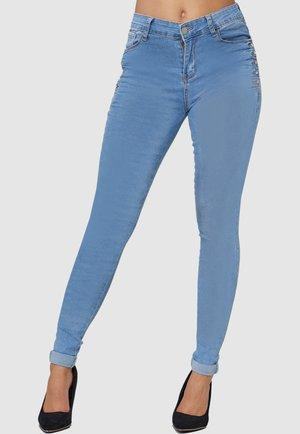
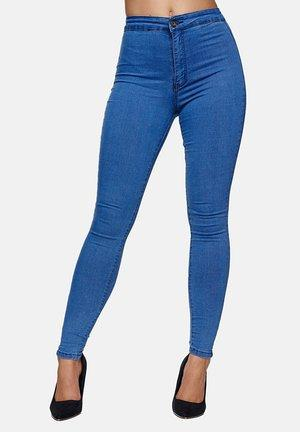
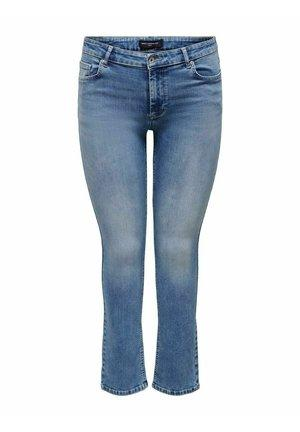
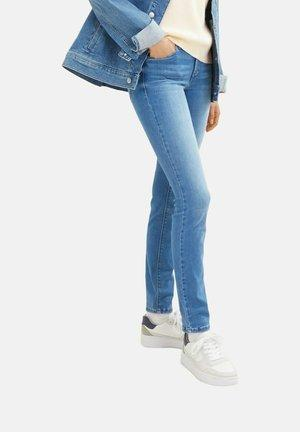
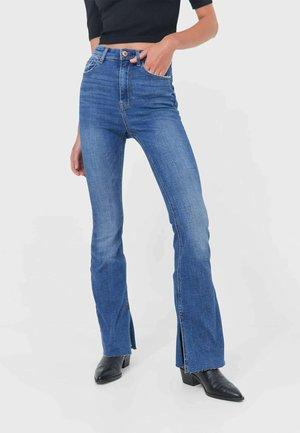
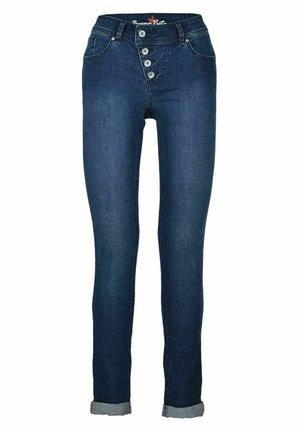
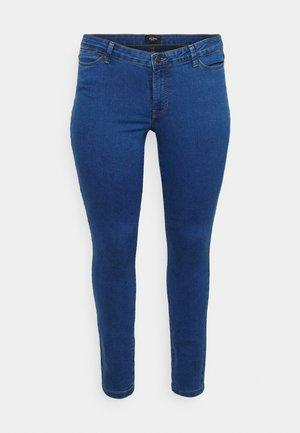
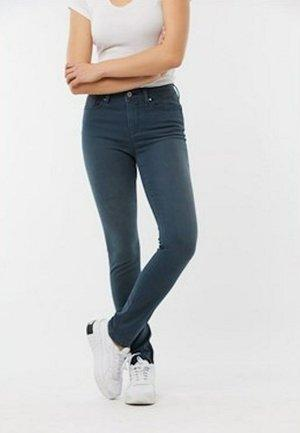
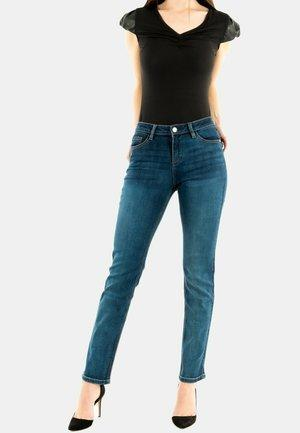
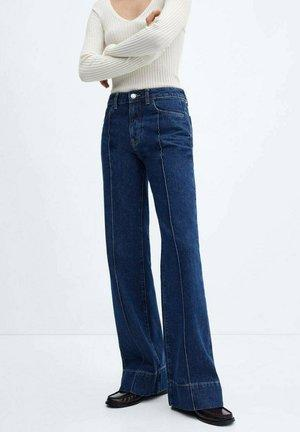



Sparse search results:  ['K3W21C00I-K11', '02R21C00B-K11', 'C5J21N006-K11', '02R21C00L-K11', 'K3W21C00G-K11', 'PE121C0V6-K11', 'BTD21C00K-T11', 'PE321N0G9-K11', 'PE121C0UY-K11', 'PE121C0UU-K11']



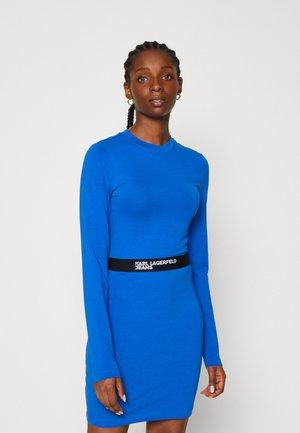
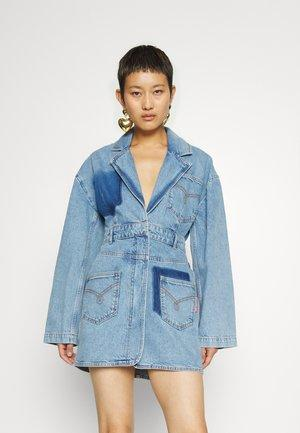
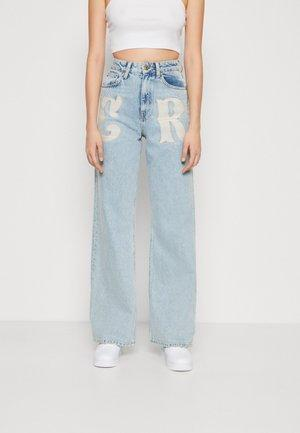
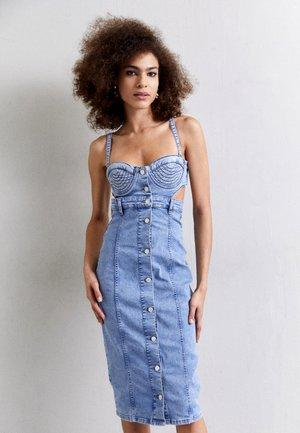
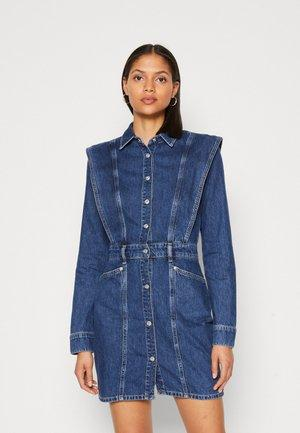
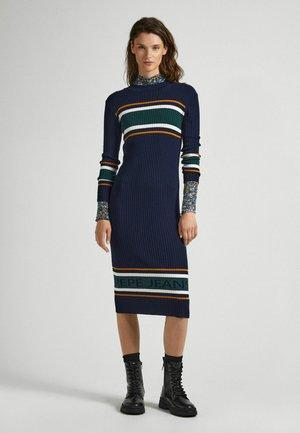
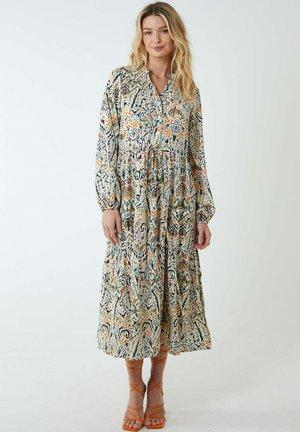
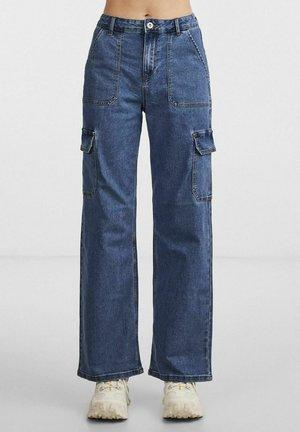
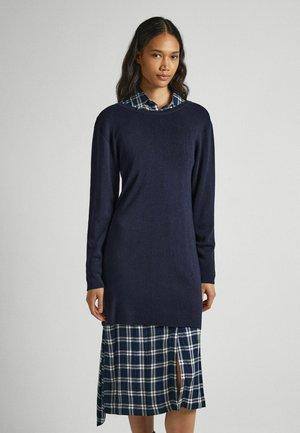
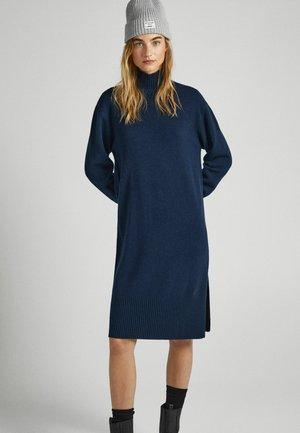



Hybrid search results:  ['MKN21N002-K16', 'E1N21N00G-K14', 'ONA21N09G-K11', 'TO221N0FD-K11', 'STH21N0BV-K11', 'BUO21N053-K12', 'VEE21N08F-K11', '1LE21N00W-K11', 'M5921N035-K11', 'M9121N1TM-K11']



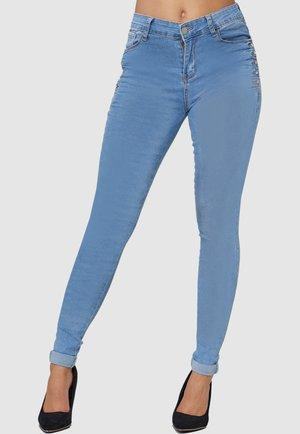
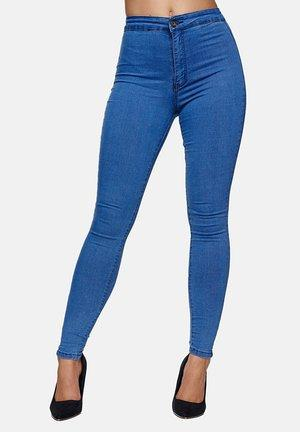
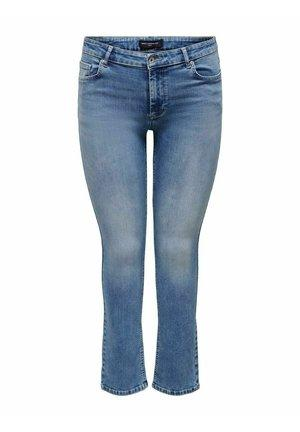
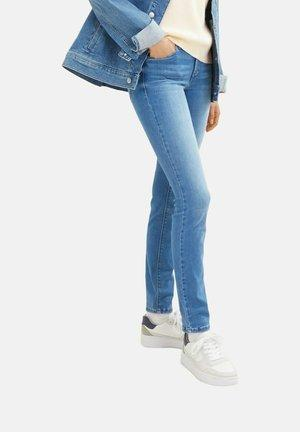
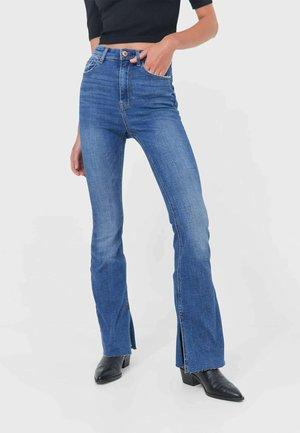
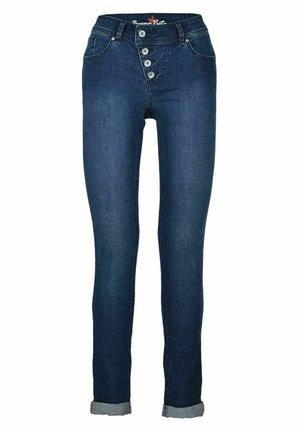
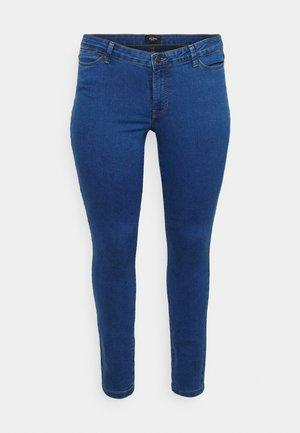
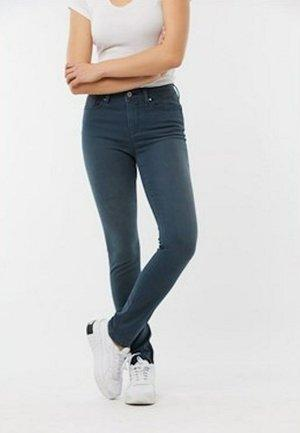
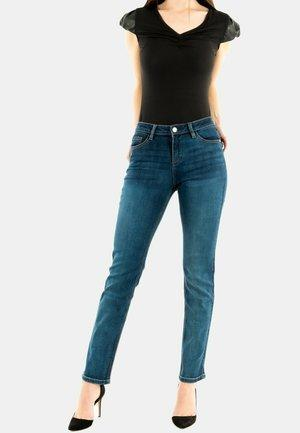
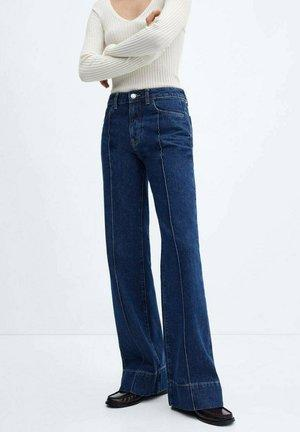

In [73]:
# enter your search query
query = "I'm looking for blue colour jeans for women"
print("User query: ", query)
print("\n")

sparse_query_embeds = bm25.embed_documents([query])[0]
dense_query_embeds = model.encode(query)    

dense_results = dense_search(collection, dense_query_embeds)
sparse_results = sparse_search(collection, sparse_query_embeds)
hybrid_results = hybrid_search(
    collection,
    dense_query_embeds,
    sparse_query_embeds,
    sparse_weight=0.5,
    dense_weight=0.5,
)

print("Dense search results: ", dense_results)
display_images(dense_results)
print("\n")

print("Sparse search results: ", sparse_results)
display_images(sparse_results)
print("\n")

print("Hybrid search results: ", hybrid_results)
display_images(hybrid_results)
print("\n")

## Disconnect Milvus Connection

In [78]:
# connections.disconnect(alias="default")